In [1]:
"""Imports Required"""

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import norm, skew
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

In [2]:
"""Model Parameters"""

S0 = 100
K = S0
mu = 0.1
sigma = 0.2
r = 0.03
T_put = 0.5
T_call = 0.75
T = 0.5
N = int(252 * T)
n_paths = 10000
shares_per_contract = 100
equity_transaction = 0.005
option_transaction = 0.01

In [3]:
def simulate_gbm(S0, mu, sigma, T, N, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    paths = np.zeros((n_paths, N + 1))
    paths[:, 0] = S0
    dW = np.random.normal(0, np.sqrt(dt), size=(n_paths, N))
    for t in range(1, N + 1):
        paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[:, t - 1])
    return paths

def create_base_df(path, K, r, sigma, T_put, T_call):
    N = len(path) - 1
    step = np.arange(N + 1)
    dt = 1 / 252
    T_put_vec = np.maximum(T_put - step * dt, 0)
    T_call_vec = np.maximum(T_call - step * dt, 0)
    put_price = bs_put(path, K, T_put_vec, r, sigma)
    put_delta = bs_put_delta(path, K, T_put_vec, r, sigma)
    put_gamma = bs_put_gamma(path, K, T_put_vec, r, sigma)
    call_price = bs_call(path, K, T_call_vec, r, sigma)
    call_delta = bs_call_delta(path, K, T_call_vec, r, sigma)
    call_gamma = bs_call_gamma(path, K, T_call_vec, r, sigma)

    return pd.DataFrame({
        'spot': path,
        'put_dte': (T_put_vec * 252).astype(int),
        'call_dte': (T_call_vec * 252).astype(int),
        'put_price': put_price,
        'put_delta': put_delta,
        'put_gamma': put_gamma,
        'call_price': call_price,
        'call_delta': call_delta,
        'call_gamma': call_gamma,
    })


def bs_put(S, K, T_put, r, sigma):
    S = np.maximum(S, 1e-8)
    T_put = np.maximum(T_put, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_put) / (sigma * np.sqrt(T_put))
    d2 = d1 - sigma * np.sqrt(T_put)
    return K * np.exp(-r * T_put) * norm.cdf(-d2) - S * norm.cdf(-d1)

def bs_put_delta(S, K, T_put, r, sigma):
    S = np.maximum(S, 1e-8)
    T_put = np.maximum(T_put, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T_put) / (sigma * np.sqrt(T_put))
    return norm.cdf(d1) - 1

def bs_put_gamma(S, K, T_put, r, sigma):
    S = np.maximum(S, 1e-8)
    T_put = np.maximum(T_put, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T_put) / (sigma * np.sqrt(T_put))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T_put))

def bs_call(S, K, T_call, r, sigma):
    S = np.maximum(S, 1e-8)
    T_call = np.maximum(T_call, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_call) / (sigma * np.sqrt(T_call))
    d2 = d1 - sigma * np.sqrt(T_call)
    return S * norm.cdf(d1) - K * np.exp(-r * T_call) * norm.cdf(d2)

def bs_call_delta(S, K, T_call, r, sigma):
    S = np.maximum(S, 1e-8)
    T_call = np.maximum(T_call, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_call) / (sigma * np.sqrt(T_call))
    return norm.cdf(d1)

def bs_call_gamma(S, K, T_call, r, sigma):
    S = np.maximum(S, 1e-8)
    T_call = np.maximum(T_call, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_call) / (sigma * np.sqrt(T_call))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T_call))

def calc_gamma_ratio(df):
    df['gamma_ratio'] = df['put_gamma']/df['call_gamma']
    return df

def calc_calls_held(df):
    df['calls_held_change'] = df['gamma_ratio'].diff()
    df.loc[0, 'calls_held_change'] = df.loc[0, 'gamma_ratio']
    return df

def calc_delta_port(df):
    df['net_port_delta'] = (df['put_delta'] * -1) + (df['gamma_ratio'] * df['call_delta'])
    return df

def calc_shares_held(df):
    df['shares_held'] = -df['net_port_delta'] * shares_per_contract
    return df

def calc_portfolio_cost(df):
    df['rebalancing_cost'] = ((df['shares_held'] -df['shares_held'].shift(1)) * df['spot']) + (abs((df['shares_held'] - df['shares_held'].shift(1)) * df['spot']) * equity_transaction) + ((df['gamma_ratio'] - df['gamma_ratio'].shift(1)) * (df['call_price'] * shares_per_contract)) + ((df['gamma_ratio'] - df['gamma_ratio'].shift(1)) * (df['call_price'] * shares_per_contract) * option_transaction)
    df.loc[0, 'rebalancing_cost'] = (df['shares_held'].iloc[0] * df['spot'].iloc[0]) + (abs(df['shares_held'].iloc[0] * df['spot'].iloc[0]) * equity_transaction) - (shares_per_contract * df['put_price'].iloc[0]) + (df['put_price'].iloc[0] * shares_per_contract * option_transaction) + (shares_per_contract * (df['call_price'].iloc[0] * df['gamma_ratio'].iloc[0])) + (df['call_price'].iloc[0] * df['gamma_ratio'].iloc[0] * shares_per_contract * option_transaction)
    df['portfolio_cost'] = df['rebalancing_cost'].cumsum()
    return df

def calc_call_pnl(df):
    df['call_pnl'] = df['gamma_ratio'].shift(1) * (df['call_price'] - df['call_price'].shift(1))
    df['call_pnl'] = df['call_pnl'].fillna(0) * shares_per_contract
    return df

def calc_put_pnl(df):
    df['put_pnl'] = df['put_price'].shift(1) - df['put_price']
    df['put_pnl'] = df['put_pnl'].fillna(0) * shares_per_contract
    return df

def calc_shares_pnl(df):
    df['shares_pnl'] = df['shares_held'].shift(1) * (df['spot'] - df['spot'].shift(1))
    df.loc[0, 'shares_pnl'] = 0
    return df

def add_interest(df, r):
    df['interest'] = df['portfolio_cost'].shift(1) * (np.exp(-r / 252) - 1)
    df.loc[0, 'interest'] = 0
    return df

def calc_overnight_pnl(df):
    df['overnight_pnl'] = df['call_pnl'] + df['put_pnl'] + df['shares_pnl'] + df['interest']
    return df

In [4]:
"""Run the simulation to create a dataframe for each path"""

paths = simulate_gbm(S0, mu, sigma, T, N, n_paths)

dfs = []
for i in range(len(paths)):
    df = create_base_df(paths[i], K, r, sigma, T_put, T_call)                      
    df = calc_gamma_ratio(df)
    df = calc_calls_held(df)
    df = calc_delta_port(df)
    df = calc_shares_held(df)
    df = calc_call_pnl(df)
    df = calc_put_pnl(df)
    df = calc_shares_pnl(df)
    df = calc_portfolio_cost(df)
    df = add_interest(df, r)
    df = calc_overnight_pnl(df)
    
    dfs.append(df)

In [5]:
"""Inspect a specfic path by accessing dataframe [n]"""

dfs[0]

,spot,put_dte,call_dte,put_price,put_delta,put_gamma,call_price,call_delta,call_gamma,gamma_ratio,calls_held_change,net_port_delta,shares_held,call_pnl,put_pnl,shares_pnl,rebalancing_cost,portfolio_cost,interest,overnight_pnl
0,100.000000,126,189,4.882222,-0.429842,2.777213e-02,7.994275,0.585703,0.022499,1.234351e+00,1.234351e+00,1.152805,-115.280536,0.000000e+00,0.000000,0.000000,-1.095711e+04,-10957.111603,0.000000,0.000000
1,98.891805,125,188,5.359747,-0.461379,2.850516e-02,7.335513,0.560179,0.023087,1.234700e+00,3.491980e-04,1.153032,-115.303180,-8.131444e+01,-47.752512,127.753291,-1.969485e+00,-10959.081087,1.304340,-0.009321
2,97.297684,124,187,6.116450,-0.507938,2.922005e-02,6.449018,0.522468,0.023761,1.229740e+00,-4.959405e-03,1.150439,-115.043855,-1.094555e+02,-75.670315,183.807230,2.212760e+01,-10936.953492,1.304575,-0.014016
3,98.252302,123,186,5.628933,-0.480669,2.902517e-02,6.935040,0.544655,0.023483,1.236021e+00,6.280218e-03,1.153874,-115.387367,5.976814e+01,48.751693,-109.822885,-2.918313e+01,-10966.136618,1.301941,-0.001116
4,96.148341,122,185,6.690284,-0.543123,2.964227e-02,5.818933,0.494013,0.024211,1.224356e+00,-1.166472e-02,1.147971,-114.797147,-1.379532e+02,-106.135079,242.770496,5.017689e+01,-10915.959724,1.305415,-0.012364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,88.262973,4,67,11.689419,-1.000000,9.779939e-07,0.619175,0.139683,0.024415,4.005639e-05,-1.253132e-03,1.000005,-100.000517,-1.604115e-02,-72.468041,71.292612,1.536496e+00,-9692.783891,1.154017,-0.037453
123,87.884367,3,66,12.079926,-1.000000,6.055582e-09,0.552402,0.128429,0.023320,2.596725e-07,-3.979672e-05,1.000000,-100.000003,-2.674678e-04,-39.050649,37.860882,4.316306e-02,-9692.740728,1.153834,-0.036200
124,88.185632,2,65,11.790561,-1.000000,4.576817e-12,0.575960,0.133327,0.024032,1.904453e-10,-2.594821e-07,1.000000,-100.000000,6.117417e-07,28.936405,-30.126528,2.632484e-04,-9692.740465,1.153829,-0.036293
125,87.638221,1,64,12.349875,-1.000000,6.455556e-25,0.491606,0.118366,0.022429,2.878265e-23,-1.904453e-10,1.000000,-100.000000,-1.606475e-09,-55.931379,54.741116,2.053506e-07,-9692.740464,1.153829,-0.036435


In [6]:
"""Print the analysis results"""

overnight_totals = [df['overnight_pnl'].sum() for df in dfs]
overnight_pnl_per_path = np.array(overnight_totals)
mean = np.mean(overnight_pnl_per_path)
std_dev = np.std(overnight_pnl_per_path)
alpha = 0.05
var = np.percentile(overnight_pnl_per_path, 100 * alpha)
cvar = overnight_pnl_per_path[overnight_pnl_per_path <= var].mean()
skewness = skew(overnight_pnl_per_path)
eqr = np.percentile(overnight_pnl_per_path, 99) - np.percentile(overnight_pnl_per_path, 1)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print(f"VaR at {alpha*100}%:", var)
print(f"CVaR at {alpha*100}%:", cvar)
print("Skewness:", skewness)
print("EQR:", eqr)

Mean: -3.178521770121655
Standard Deviation: 6.318434858721489
VaR at 5.0%: -10.22356906383119
CVaR at 5.0%: -16.986938346476446
Skewness: 0.2204321480252904
EQR: 41.673948647444774


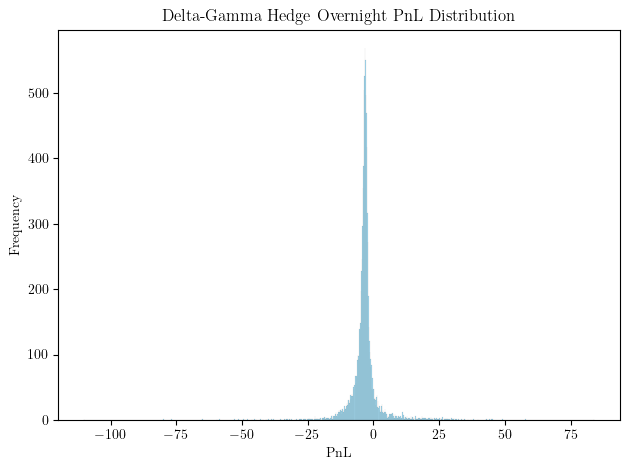

In [7]:
"""Plot the Overnight PnL Distributions"""

sns.histplot(overnight_pnl_per_path, bins=1000, color='skyblue')
plt.title("Delta-Gamma Hedge Overnight PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

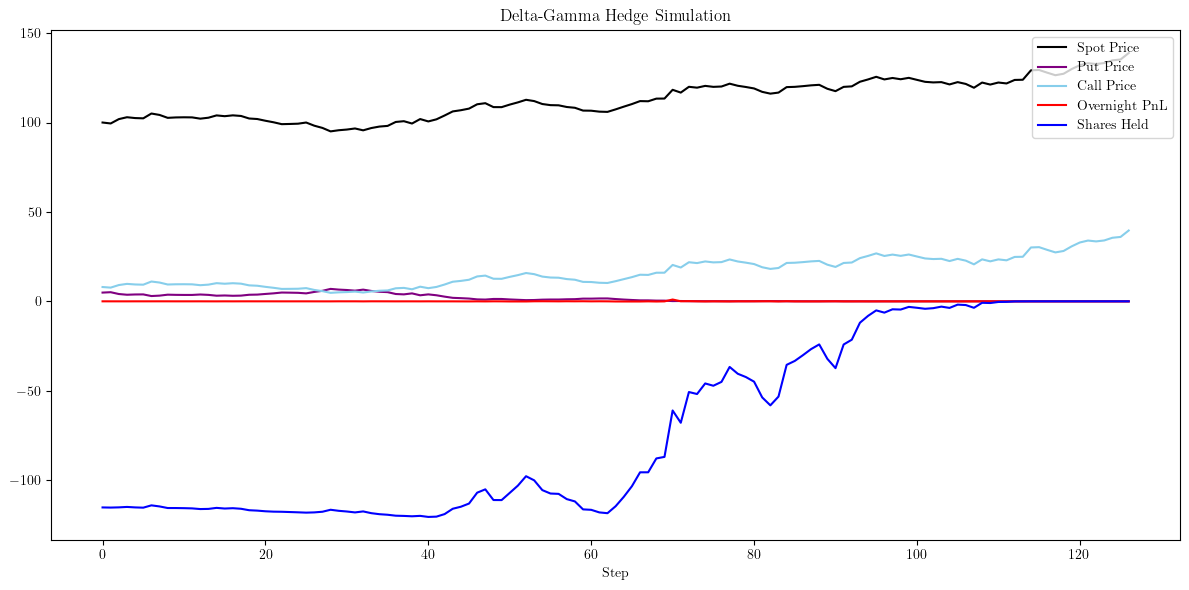

In [8]:
"""Plot the path simulation"""

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title("Delta-Gamma Hedge Simulation")
ax1.set_xlabel("Step")
ax1.plot(df.index, df['spot'], label='Spot Price', color='black')
ax1.plot(df.index, df['put_price'], label='Put Price', color='purple')
ax1.plot(df.index, df['call_price'], label='Call Price', color='skyblue')
ax1.plot(df.index, df['overnight_pnl'], label='Overnight PnL', color='red')
ax1.plot(df.index, df['shares_held'], label='Shares Held', color='blue')
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()